## Bots and Gender Profiling
https://pan.webis.de/clef19/pan19-web/author-profiling.html

####  data preprocessing

In [14]:
import ssl
import html
import IPython
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import re
import seaborn as sns
import sys
import xml.etree.ElementTree as ElementTree

from dataset import Dataset
from itertools import zip_longest
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from pathlib import Path

# https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#tokenizer
nltk.download('punkt')
#stopwords
nltk.download('stopwords')
#lemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/enoch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/enoch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/enoch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [15]:
dataset = Dataset(Path("./dataset/pan19-author-profiling-training-2019-02-18/en"),
  Path("./dataset/pan19-author-profiling-training-2019-02-18/en_labels/truth.txt"),
  Path("./dataset/pan19-author-profiling-test-2019-04-29/en"),
  Path("./dataset/pan19-author-profiling-test-2019-04-29/truth.txt"))

xtrain, ytrain, xtest, ytest = dataset.get_data()
print(len(xtrain), len(ytrain))
print(len(xtest), len(ytest))

4120 4120
2640 2640


In [16]:
d = {'author': [], 'tweet': [], 'bot': []}
for author in xtrain:
    for tweet in xtrain[author]:
        d['author'].append(author)
        d['tweet'].append(tweet)
        d['bot'].append(ytrain[author][0])

df_train = pd.DataFrame(d, columns=['author', 'tweet', 'bot'])

d = {'author': [], 'tweet': [], 'bot': []}
for author in xtest:
    for tweet in xtest[author]:
        d['author'].append(author)
        d['tweet'].append(tweet)
        d['bot'].append(ytest[author][0])

df_test = pd.DataFrame(d, columns=['author', 'tweet', 'bot'])

print(f"train size: {df_train.shape}, test size: {df_test.shape}")

train size: (412000, 3), test size: (264000, 3)


In [17]:
# complete dataset
df = pd.concat([df_train, df_test])
print(f"df size: {df.shape}")
df

df size: (676000, 3)


,author,tweet,bot
0,47b0c91666f8e47948049eb1fc2202f9,Town &amp; Country Magazine Uninvited Monica L...,bot
1,47b0c91666f8e47948049eb1fc2202f9,Lead Business Systems Analyst – Automated Test...,bot
2,47b0c91666f8e47948049eb1fc2202f9,"Senior Software Engineer, Business Process Eng...",bot
3,47b0c91666f8e47948049eb1fc2202f9,Technical Support Engineer: Technical Support ...,bot
4,47b0c91666f8e47948049eb1fc2202f9,Mueller questioned Novartis payment to Trump l...,bot
...,...,...,...
263995,4e14afaa7e24e0498891cbe13f0213ff,"I appreciate this councilman, but as someone w...",human
263996,4e14afaa7e24e0498891cbe13f0213ff,RT @ShaneGoldmacher: NEWS: Andrew Cuomo just a...,human
263997,4e14afaa7e24e0498891cbe13f0213ff,RT @ShaneGoldmacher: NEW: On his first day in ...,human
263998,4e14afaa7e24e0498891cbe13f0213ff,RT @brianschatz: In no particular order: I’m 4...,human


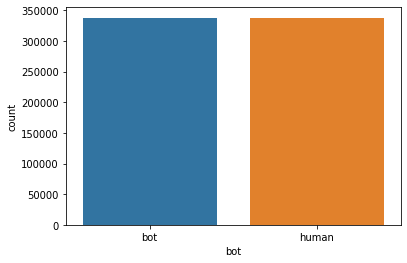

In [5]:
sns.countplot(df['bot'])

## Preproc

In [6]:
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer() 

def replace_num_token(text, replace_with = ''):
    """ Replace all numbers with a unique token.
    """
    text = re.sub(r"\d+", replace_with, text).strip()
    return text

def clean_text(text):    
    # lowercase 
    text = text.lower()
    
    # remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", 'URL_TOKEN', text, flags=re.MULTILINE)
    
    # maybe strip tags
    text = re.sub(r'\@\w+|\#','RT_TOKEN', text)
    
    # strip html tags
    text = html.unescape(text)
    
    # remove non-words
    text = re.sub('\W', ' ', text)
    
    # remove single chars
    text = re.sub(r'(?:^| )\w(?:$| )', ' ', text)
    
    # replace numbers with NUM_TOKEN
    text = replace_num_token(text, 'NUM_TOKEN')
    
    # tokenize
    tokenized = tokenizer.tokenize(text)
    tokenized = list(map(lambda x : lemmatizer.lemmatize(x), tokenized))

    # remove stopwords
    words = [w for w in tokenized if not w in stopwords.words('english')]

    return " ".join(words)
  

In [7]:
df_train['clean_tweet'] = df_train['tweet'].apply(lambda x: clean_text(x))
df_train

,author,tweet,bot,clean_tweet
0,47b0c91666f8e47948049eb1fc2202f9,Town &amp; Country Magazine Uninvited Monica L...,bot,town country magazine uninvited monica lewinsk...
1,47b0c91666f8e47948049eb1fc2202f9,Lead Business Systems Analyst – Automated Test...,bot,lead business system analyst automated testing...
2,47b0c91666f8e47948049eb1fc2202f9,"Senior Software Engineer, Business Process Eng...",bot,senior software engineer business process engi...
3,47b0c91666f8e47948049eb1fc2202f9,Technical Support Engineer: Technical Support ...,bot,technical support engineer technical support e...
4,47b0c91666f8e47948049eb1fc2202f9,Mueller questioned Novartis payment to Trump l...,bot,mueller questioned novartis payment trump lawy...
...,...,...,...,...
411995,70ddcdd222a02d2df685e67a38b903d7,"A little more persistence, a little more effor...",bot,little persistence little effort seemed hopele...
411996,70ddcdd222a02d2df685e67a38b903d7,Perseverance is a great element of success. If...,bot,perseverance great element success knock long ...
411997,70ddcdd222a02d2df685e67a38b903d7,Profit is a by-product of work; happiness is i...,bot,profit product work happiness chief product he...
411998,70ddcdd222a02d2df685e67a38b903d7,Quality questions create a quality life. Succe...,bot,quality question create quality life successfu...


In [8]:
df_test['clean_tweet'] = df_test['tweet'].apply(lambda x: clean_text(x))
df_test

,author,tweet,bot,clean_tweet
0,b19731f08be7bd0632df805933a00b31,"So, are you ready? You know what I’m talking a...",bot,ready know talking ready
1,b19731f08be7bd0632df805933a00b31,Warm thanks to everyone for support and encour...,bot,warm thanks everyone support encouragement jim...
2,b19731f08be7bd0632df805933a00b31,RT @Jim_Rohn_Quotes: “We must all suffer one o...,bot,rt RT_TOKEN must suffer one two thing pain dis...
3,b19731f08be7bd0632df805933a00b31,RT @Jim_Rohn_Quotes: “Happiness is not somethi...,bot,rt RT_TOKEN happiness something postpone futur...
4,b19731f08be7bd0632df805933a00b31,RT @Jim_Rohn_Quotes: “It is the set of the sai...,bot,rt RT_TOKEN set sail direction wind determines...
...,...,...,...,...
263995,4e14afaa7e24e0498891cbe13f0213ff,"I appreciate this councilman, but as someone w...",human,appreciate councilman someone involved plannin...
263996,4e14afaa7e24e0498891cbe13f0213ff,RT @ShaneGoldmacher: NEWS: Andrew Cuomo just a...,human,rt RT_TOKEN news andrew cuomo announced granti...
263997,4e14afaa7e24e0498891cbe13f0213ff,RT @ShaneGoldmacher: NEW: On his first day in ...,human,rt RT_TOKEN new first day office andrew cuomo ...
263998,4e14afaa7e24e0498891cbe13f0213ff,RT @brianschatz: In no particular order: I’m 4...,human,rt RT_TOKEN particular order NUM_TOKEN people ...


In [9]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top n most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(15,terms / 5))
    ax = sns.barplot(data=d, x= "count", y = "word", color='lightseagreen')
    ax.set(ylabel = 'Word')

    plt.show()
    return words_df.shape[0]

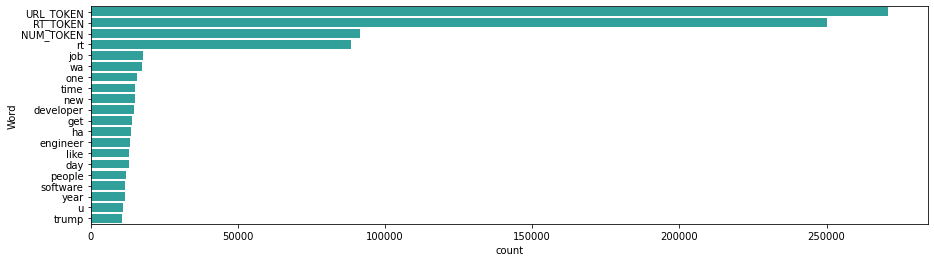

Number of distinct words in dataset: 131523


In [10]:
# print 20 most frequent words, with URL_TOKEN
size = freq_words(df_train['clean_tweet'], 20)
print(f"Number of distinct words in dataset: {size}")

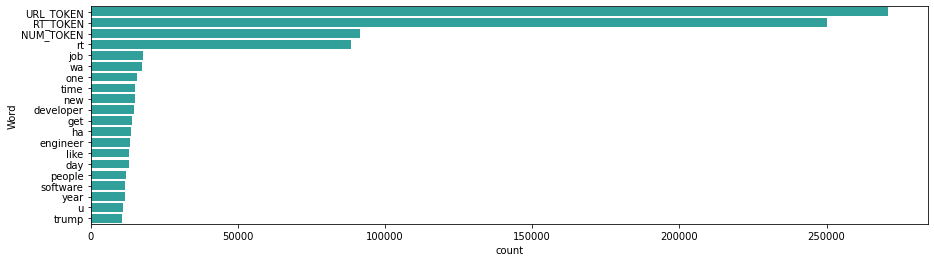

Number of distinct words in dataset: 131523


In [11]:
# print 20 most frequent words
size = freq_words(df_train['clean_tweet'], 20)
print(f"Number of distinct words in dataset: {size}")

In [12]:
df_train.to_pickle("./pan19_df_clean_train_feateng.pkl")

In [13]:
df_test.to_pickle("./pan19_df_clean_test_feateng.pkl")